In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import os
from PIL import Image


In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define class names
class_names = ['FreshApple', 'RottenApple', 'FreshBanana', 'RottenBanana', 'FreshMango', 'RottenMango', 
               'FreshOrange', 'RottenOrange', 'FreshStrawberry', 'RottenStrawberry',
               'FreshCarrot', 'RottenCarrot', 'FreshTomato', 'RottenTomato', 'FreshCucumber', 'RottenCucumber', 
               'FreshPotato', 'RottenPotato', 'FreshBellpepper', 'RottenBellpepper', 
               'FRESH_FISH', 'HIGHLY_FRESH_FISH', 'SPOILED_FISH',
               'FRESH_MEAT', 'HALF_FRESH_MEAT', 'SPOILED_MEAT']

In [4]:
print(f"Total classes: {len(class_names)}")


Total classes: 26


In [5]:
# Categorize classes into freshness categories
fresh_classes = {'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
                 'FreshCarrot', 'FreshTomato', 'FreshCucumber', 'FreshPotato', 'FreshBellpepper',
                 'FRESH_FISH', 'HIGHLY_FRESH_FISH', 'FRESH_MEAT'}

half_fresh_classes = {'HALF_FRESH_MEAT'}

rotten_classes = {'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
                  'RottenCarrot', 'RottenTomato', 'RottenCucumber', 'RottenPotato', 'RottenBellpepper',
                  'SPOILED_FISH', 'SPOILED_MEAT'}

# Function to categorize predictions
def categorize_label(predicted_label):
    if predicted_label in fresh_classes:
        return "Fresh"
    elif predicted_label in half_fresh_classes:
        return "Half Fresh"
    elif predicted_label in rotten_classes:
        return "Rotten"
    else:
        return "I cannot identify this image."

In [6]:
print(categorize_label("FreshMango"))  # Should print "Fresh"
print(categorize_label("SPOILED_FISH"))  # Should print "Rotten"
print(categorize_label("HALF_FRESH_MEAT"))  # Should print "Half Fresh"
print(categorize_label("Unknown_Item"))  # Should print "I cannot identify this image."



Fresh
Rotten
Half Fresh
I cannot identify this image.


In [7]:
# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation((-10,10)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

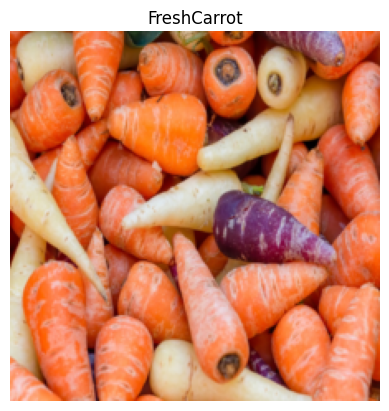

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (modify as per your dataset's requirement)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 if required
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)", transform=transform)
loader = DataLoader(dataset, batch_size=3, shuffle=True)

# Get class names
class_names = dataset.classes  # Ensure correct mapping

# Get a batch of images and labels
images, labels = next(iter(loader))

# Select the first image
img = images[0].numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

# Unnormalize correctly
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img * std + mean  # Unnormalize

# Clip values to ensure they are in the valid range [0,1] for display
img = np.clip(img, 0, 1)

# Display the image
plt.imshow(img)
plt.title(class_names[labels[0].item()])  # Convert tensor to int
plt.axis("off")  # Hide axes
plt.show()


In [9]:
import os

dataset_path = "/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)"

# Check if dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path '{dataset_path}' does not exist. Please check the path!")

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Check if dataset is empty
if len(dataset) == 0:
    raise ValueError("Dataset is empty. Please check the dataset folder and image structure.")

# Print class names for verification
print(f"Total Classes Found: {len(dataset.classes)}")
print("Class Names:", dataset.classes)


Total Classes Found: 26
Class Names: ['FRESH_FISH', 'FRESH_MEAT', 'FreshApple', 'FreshBanana', 'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshMango', 'FreshOrange', 'FreshPotato', 'FreshStrawberry', 'FreshTomato', 'HALF_FRESH_MEAT', 'HIGHLY_FRESH_FISH', 'RottenApple', 'RottenBanana', 'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenMango', 'RottenOrange', 'RottenPotato', 'RottenStrawberry', 'RottenTomato', 'SPOILED_FISH', 'SPOILED_MEAT']


In [10]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Set random seed for reproducibility
torch.manual_seed(42)

# Define train-validation split ratio
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Get targets (labels) for stratification
targets = np.array([label for _, label in dataset.samples])

# Perform stratified split
train_indices, val_indices = train_test_split(
    np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Create dataset subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print dataset sizes for verification
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 14924
Validation set size: 3732


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained models
resnet50 = models.resnet50(weights="IMAGENET1K_V1").to(device)
googlenet = models.googlenet(weights="IMAGENET1K_V1").to(device)
densenet121 = models.densenet121(weights="IMAGENET1K_V1").to(device)

# Modify the classifier layers to include dropout and match 26 output classes
# For ResNet50, replace the final fully connected layer with a Sequential block including dropout.
resnet50.fc = nn.Sequential(
    nn.Dropout(0.5),              # Dropout with 50% probability
    nn.Linear(in_features=2048, out_features=26)
)

# For GoogleNet, modify the final fully connected layer similarly.
googlenet.fc = nn.Sequential(
    nn.Dropout(0.4),              # Dropout with 40% probability
    nn.Linear(in_features=1024, out_features=26)
)

# For DenseNet121, modify the classifier to include dropout.
densenet121.classifier = nn.Sequential(
    nn.Dropout(0.5),              # Dropout with 50% probability
    nn.Linear(in_features=1024, out_features=26)
)

# Optional: Set models to evaluation mode when doing inference
resnet50.eval()
googlenet.eval()
densenet121.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizer_resnet = optim.Adam(resnet50.parameters(), lr=0.0001)
optimizer_googlenet = optim.Adam(googlenet.parameters(), lr=0.0001)
optimizer_densenet = optim.Adam(densenet121.parameters(), lr=0.0001)


In [13]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs=1):
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")

    return model


In [14]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return correct / total


In [15]:
resnet50 = train_model(resnet50, optimizer_resnet, train_loader, val_loader, num_epochs=40)
googlenet = train_model(googlenet, optimizer_googlenet, train_loader, val_loader, num_epochs=40)
densenet121 = train_model(densenet121, optimizer_densenet, train_loader, val_loader, num_epochs=40)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/40 - Train Loss: 0.6236, Train Acc: 0.7958, Val Acc: 0.8792
Epoch 2/40 - Train Loss: 0.2587, Train Acc: 0.9038, Val Acc: 0.8968
Epoch 3/40 - Train Loss: 0.1830, Train Acc: 0.9311, Val Acc: 0.9003
Epoch 4/40 - Train Loss: 0.1378, Train Acc: 0.9511, Val Acc: 0.9073
Epoch 5/40 - Train Loss: 0.1020, Train Acc: 0.9645, Val Acc: 0.9183
Epoch 6/40 - Train Loss: 0.0888, Train Acc: 0.9683, Val Acc: 0.9046
Epoch 7/40 - Train Loss: 0.0689, Train Acc: 0.9761, Val Acc: 0.9121
Epoch 8/40 - Train Loss: 0.0480, Train Acc: 0.9853, Val Acc: 0.9094
Epoch 9/40 - Train Loss: 0.0618, Train Acc: 0.9788, Val Acc: 0.9078
Epoch 10/40 - Train Loss: 0.0552, Train Acc: 0.9811, Val Acc: 0.9191
Epoch 11/40 - Train Loss: 0.0533, Train Acc: 0.9827, Val Acc: 0.9089
Epoch 12/40 - Train Loss: 0.0432, Train Acc: 0.9861, Val Acc: 0.9086
Epoch 13/40 - Train Loss: 0.0307, Train Acc: 0.9906, Val Acc: 0.9043
Epoch 14/40 - Train Loss: 0.0376, Train Acc: 0.9894, Val Acc: 0.9092
Epoch 15/40 - Train Loss: 0.0397, Train Acc

In [16]:
torch.save(resnet50.state_dict(), "resnet50_freshness.pth")
torch.save(googlenet.state_dict(), "googlenet_freshness.pth")
torch.save(densenet121.state_dict(), "densenet121_freshness.pth")
